# Linear Regression Model

## Imports

### Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from loguru import logger
from tracks_import import read_from_csv


### Import the data

In [3]:
# Specify the paths and track id
dataset_dir = "../../datasets/inD/data/"
recording = "00"


if not os.path.isdir(dataset_dir):
    raise Exception("Directory does not exist")

# Create paths to csv files
tracks_file = dataset_dir + recording + "_tracks.csv"
tracks_meta_file = dataset_dir + recording + "_tracksMeta.csv"
recording_meta_file = dataset_dir + recording + "_recordingMeta.csv"

if not os.path.isfile(tracks_file) or not os.path.isfile(tracks_meta_file) or not os.path.isfile(recording_meta_file):
    raise Exception("File does not exist")
# Load csv files
logger.info("Loading csv files {}, {} and {}", tracks_file, tracks_meta_file, recording_meta_file)
tracks, static_info, meta_info = read_from_csv(tracks_file, tracks_meta_file, recording_meta_file,
                                                   include_px_coordinates=True)


df_tracks = pd.DataFrame(tracks)
df_tracks
df_static_info = pd.DataFrame(static_info)
df_static_info
df_meta_info = pd.DataFrame(meta_info.items())
df_meta_info
## Data preprocessing

### Select the track(s)
track_ids = [i for i in range(382)]
#track_ids = [1, 2]
selected_tracks = df_tracks[df_tracks['trackId'].isin(track_ids)]
selected_tracks

# Change the position to the distance by subtracting the starting position from the position lists
selected_tracks.loc[:, 'xCenter'] = selected_tracks['xCenter'].apply(lambda num: [x - num[0] for x in num[:]])
selected_tracks.loc[:, 'yCenter'] = selected_tracks['yCenter'].apply(lambda num: [x - num[0] for x in num[:]])
selected_tracks

# Select distance, velocity and acceleraion columns
x_dis = np.concatenate(selected_tracks['xCenter'].values)
y_dis = np.concatenate(selected_tracks['yCenter'].values)
x_vel = np.concatenate(selected_tracks['xVelocity'].values)
y_vel = np.concatenate(selected_tracks['yVelocity'].values)
x_acc = np.concatenate(selected_tracks['xAcceleration'].values)
y_acc = np.concatenate(selected_tracks['yAcceleration'].values)

# Select distance, velocity and acceleraion columns
s_x = np.concatenate(selected_tracks['xCenter'].values)
s_y = np.concatenate(selected_tracks['yCenter'].values)
v_x = np.concatenate(selected_tracks['xVelocity'].values)
v_y = np.concatenate(selected_tracks['yVelocity'].values)
a_x = np.concatenate(selected_tracks['xAcceleration'].values)
a_y = np.concatenate(selected_tracks['yAcceleration'].values)




2023-12-30 13:44:43.778 | INFO     | __main__:<module>:17 - Loading csv files ../../datasets/inD/data/00_tracks.csv, ../../datasets/inD/data/00_tracksMeta.csv and ../../datasets/inD/data/00_recordingMeta.csv


## Linear Regressor

In [4]:
def perform_linear_regression(A, t):
    X_train, X_test, y_train, y_test = train_test_split(A, t, test_size=0.2, random_state=69)

    ### Fitting
    model = LinearRegression()
    model.fit(X_train, y_train)

    ### Coefficients
    print('Coefficients:')
    for x in model.coef_:
        print(x)

    ### Evaluation
    #### MSE
    # Use the model to predict on the test set
    predictions = model.predict(X_test)

    # Evaluate the performance
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse}')

    #### R-score
    # Calculate R-squared
    r2 = r2_score(y_test, predictions)
    print("R-squared (R2) Score:", r2)

    #### Residual plot
    # Calculate residuals
    residuals = y_test - predictions

    # Create a scatter plot of predicted vs actual values
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.title('Residuals Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2)  # Add a horizontal line at y=0
    plt.show()

    # Plotting Predicted vs. Actual
    plt.scatter(y_test, predictions)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)  # Diagonal line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual Plot")
    plt.show()

## New model (4 parameters)

Here we solve the following system:
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_x(k-1) \\ 
        a_y(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k-1) + v_x(k)  & 0 & 0                   \\ 
        0 & 0 & -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k)  & v_y(k-1) - v_y(k)  & 0 & 0                   \\
        0 & 0 & -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}


We split the model into two models for easier implementation

\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1) \\ 
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k-1) + v_x(k)   \\ 
        -a_y(k)  & v_y(k-1) + v_y(k)   \\
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
   \end{bmatrix}
\end{align}



\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_3 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}


Note: $dt = 0.04$



Our model is in the form of:
\begin{equation}
t = Ax
\end{equation}

We can solve this using least squares
\begin{equation}
||t-Ax||^2
\end{equation}



### Data shifting

In [61]:
# Target vector t
t = np.concatenate([a_x[1:-1], a_y[1:-1]])    # a(k)
t.shape

 

(410362,)

In [62]:
# A vector for the first model
A = - a_x[0:-2]                  # -a_y(k-1)  
B = - a_y[0:-2]                  # -a_y(k-1)  
C = v_x[2:] - v_x[1:-1]        # v_x(k+1) - v_x(k)
D = v_y[2:] - v_y[1:-1]        # v_y(k+1) - v_y(k)

N = np.vstack((
    np.column_stack((A, B)), 
    np.column_stack((C, D))
    ))
N.shape


(410362, 2)

In [63]:
# A vector for the second model
dt = 0.04

A = - a_x[0:-2]                                  # - a_x(k-1)  
B = - a_y[0:-2]                                  # - a_y(k-1)  
C = s_x[2:] - s_x[1:-1] - dt * v_x[1:-1]        # s_x(k+1) - s_x(k) - dt v_x(k)
D = s_y[2:] - s_y[1:-1] - dt * v_y[1:-1]        # s_y(k+1) - s_y(k) - dt v_y(k)

print(A.shape)
print(B.shape)
print(C.shape)
print(D.shape)

(205181,)
(205181,)
(205181,)
(205181,)


In [64]:

M = np.vstack((
    np.column_stack((A, B)), 
    np.column_stack((C, D))
    ))
M.shape


(410362, 2)

### Linear Regression


Coefficients:
-0.489131150371867
0.18651215079451156
Mean Squared Error: 0.23532214513356525
R-squared (R2) Score: 0.27721035748292777


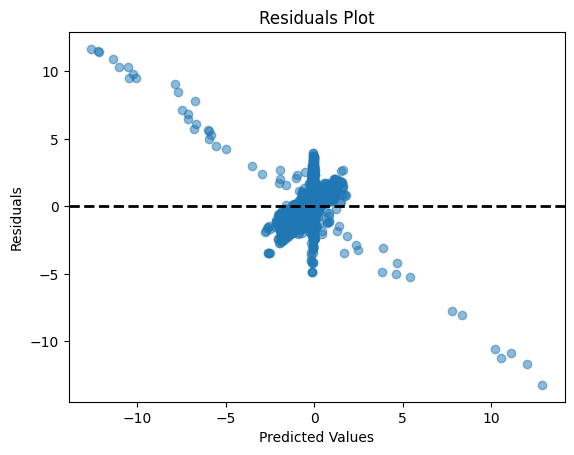

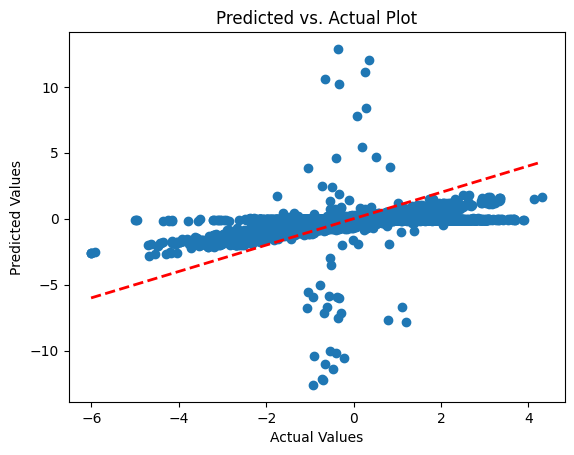

In [65]:
# First model
perform_linear_regression(N, t)


Coefficients:
-0.06956758966832251
0.08446579566301102
Mean Squared Error: 0.31496134324357433
R-squared (R2) Score: 0.03259934775578022


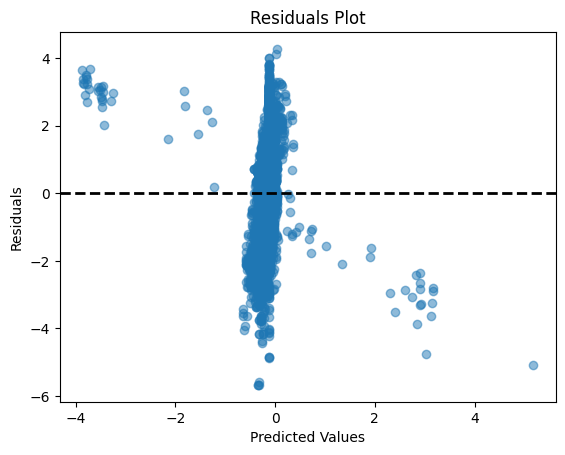

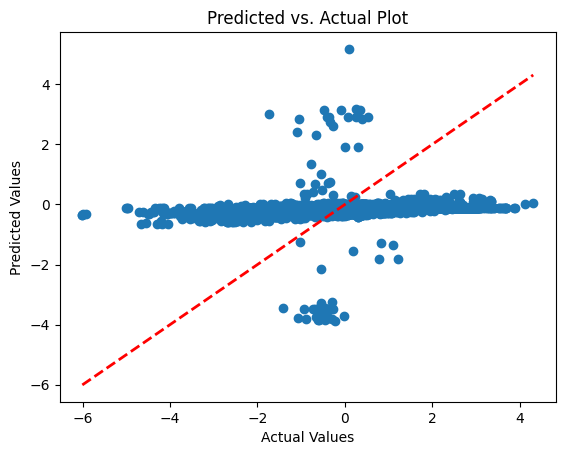

In [66]:
# Secon model
perform_linear_regression(M, t)

## Acceleration model (8 parameter)

In [5]:
# A vector for the second model
dt = 0.4

A = - a_x[1:-1]                                  # - a_x(k)  
B = - a_y[1:-1]                                  # - a_y(k)  
C = s_x[2:] - s_x[1:-1] - dt * v_x[1:-1]        # s_x(k+1) - s_x(k) - dt v_x(k)
D = s_y[2:] - s_y[1:-1] - dt * v_y[1:-1]        # s_y(k+1) - s_y(k) - dt v_y(k)

print(A.shape)
print(B.shape)
print(C.shape)
print(D.shape)

(205181,)
(205181,)
(205181,)
(205181,)


Here we solve the following system

$$ s_i(k+1) - s_i(k) = 
    \begin{bmatrix} 
         s_i(k-1) 
        &s_i(k-2) 
        &v_i(k)   
        &v_i(k-1)
        &v_i(k+1)
        &v_i(k)  
        &v_i(k-1) 
        &v_i(k-2) 
    \end{bmatrix} 
    \begin{bmatrix} 
        \theta_{s_1}                                 
        \\ \theta_{s_2}                                 
        \\ \theta_{s_3}                                 
        \\ \theta_{s_4}                                
        \\ \frac{\theta_{s_5}}{\theta_{v_4}}            
        \\ \frac{\theta_{s_5}\theta_{v_1}}{\theta_{v_4}}
        \\ \frac{\theta_{s_5}\theta_{v_2}}{\theta_{v_4}}
        \\ \frac{\theta_{s_5}\theta_{v_3}}{\theta_{v_4}}
    \end{bmatrix} $$

To solve this we use:
$$\begin{equation}
||t-Ax||^2
\end{equation}$$


### Data shifting

In [6]:
# for the x entries
A_x = np.column_stack([
    s_x[1:-2],          # s_i(k-1)
    s_x[0:-3],          # s_i(k-2)
    v_x[2:-1],          # v_i(k)
    v_x[1:-2],          # v_i(k-1)
    v_x[3:],            # v_i(k+1)
    v_x[2:-1],          # v_i(k)
    v_x[1:-2],          # v_i(k-1)
   -v_x[0:-3]           # -v_i(k-2)
]).T

t_x = np.array(s_x[3:] - s_x[2:-1])

print("A matrix: " + str(A_x.shape))
print("Target Matrix: " + str(np.array(t_x).shape))


A matrix: (8, 205180)
Target Matrix: (205180,)


In [7]:
# For the y entries
A_y = np.vstack((
    s_y[1:-2],          # s_i(k-1)
    s_y[0:-3],          # s_i(k-2)
    v_y[2:-1],          # v_i(k)
    v_y[1:-2],          # v_i(k-1)
    v_y[3:],            # v_i(k+1)
    v_y[2:-1],          # v_i(k)
    v_y[1:-2],          # v_i(k-1)
   -v_y[0:-3]           # -v_i(k-2)
))


#A_y = np.vstack([
#    s_y[1:-2],          # s_i(k-1)
#    s_y[0:-3],          # s_i(k-2)
#    v_y[2:-1],          # v_i(k)
#    v_y[1:-2],          # v_i(k-1)
#    v_y[3:],            # v_i(k+1)
#    v_y[2:-1],          # v_i(k)
#    v_y[1:-2],          # v_i(k-1)
#   -v_y[0:-3]           # -v_i(k-2)
#]).T

t_y = np.array(s_y[3:] - s_y[2:-1])

print("A matrix: " + str(A_y.shape))
print("Target Matrix: " + str(np.array(t_y).shape))


A matrix: (8, 205180)
Target Matrix: (205180,)


### Regressor

In [8]:
# linear regression for x 
perform_linear_regression(A_x, t_x)

ValueError: Found input variables with inconsistent numbers of samples: [8, 205180]

Coefficients:
0.0006792461844549605
-0.004052169374766621
-2.146379095515427
-0.000769961224483957
4.292224994096708
-2.1463790955154294
-0.0007699612244868438
-0.032086182799419063
Mean Squared Error: 2.722245697276701
R-squared (R2) Score: 0.5550913899342822


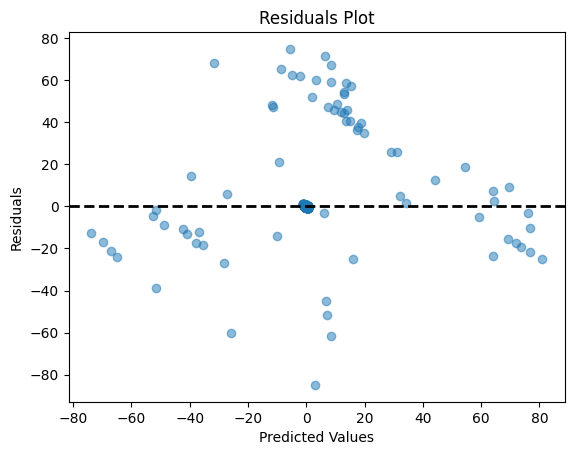

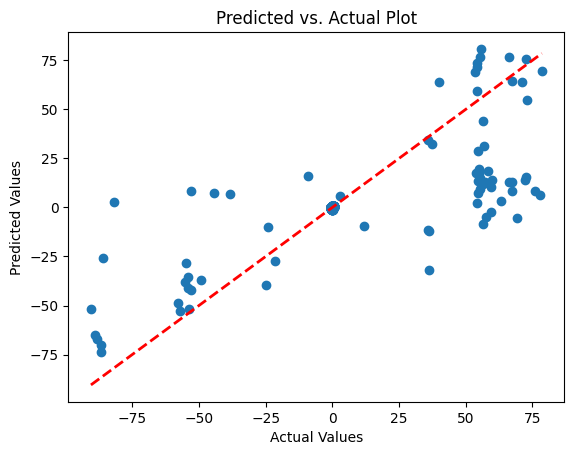

In [25]:
# linear regression for y
perform_linear_regression(A_y, t_y)

## Acceleration model (8 parameter + 1)

Here we solve for the system as above, but add one more parameter to estimate for a 9th parameter

$$\Bigg\| 
\begin{bmatrix}
t \\ 0
\end{bmatrix}
-
\begin{bmatrix}
A & 0\\ 
0 & \mathbb{I} * \sqrt{\lambda}
\end{bmatrix}
\begin{bmatrix}
x \\
x"
\end{bmatrix}
\Bigg\| ^2
$$

Here we solve the following system

$$\begin{align}
t &=   s_i(k+1) - s_i(k) \\
A &=  \begin{bmatrix} 
         s_i(k-1) 
        &s_i(k-2) 
        &v_i(k)   
        &v_i(k-1)
        &v_i(k+1)
        &v_i(k)  
        &v_i(k-1) 
        &v_i(k-2) 
    \end{bmatrix} \\
x &= \begin{bmatrix} 
        \theta_{s_1}                                 
        \\ \theta_{s_2}                                 
        \\ \theta_{s_3}                                 
        \\ \theta_{s_4}                                
        \\ \frac{\theta_{s_5}}{\theta_{v_4}}            
        \\ \frac{\theta_{s_5}\theta_{v_1}}{\theta_{v_4}}
        \\ \frac{\theta_{s_5}\theta_{v_2}}{\theta_{v_4}}
        \\ \frac{\theta_{s_5}\theta_{v_3}}{\theta_{v_4}}
    \end{bmatrix} \\

\end{align}
$$

In [26]:
# Create the design matrix A based on your formula
A_x = np.vstack([
    s_x[1:-2],          # s_i(k-1)
    s_x[0:-3],          # s_i(k-2)
    v_x[2:-1],          # v_i(k)
    v_x[1:-2],          # v_i(k-1)
    v_x[3:],            # v_i(k+1)
    v_x[2:-1],          # v_i(k)
    v_x[1:-2],          # v_i(k-1)
   -v_x[0:-3]           # -v_i(k-2)
]).T

t_x = np.array(s_x[3:] - s_x[2:-1])          # s_i(k+1) - s_i(k)

print("A matrix: " + str(A_x.shape))
print("Target Matrix: " + str(np.array(t_x).shape))


A matrix: (205180, 8)
Target Matrix: (205180,)


In [27]:
def add_identity_block(A, B):
    B_zero = np.zeros((len(B), len(A.T)))
    A_zero = np.zeros((len(A), len(B.T)))
    return np.block([
        [A, A_zero], 
        [B_zero, B]])

n = 1               # Number of additional parameters
lambda_val = 0.9
identity_matrix = np.eye(n) * lambda_val

A_block= add_identity_block(A_x, identity_matrix)
target_block = np.concatenate([t_x, np.zeros(n)])


print("A matrix: " + str(A_block.shape))
print("t matrix: " + str(target_block.shape))

A matrix: (205181, 9)
t matrix: (205181,)


Coefficients:
-0.002476674948458898
-0.002965542010602479
-1.9745020553998223
0.004545597368920395
3.956655020242682
-1.9745020553998185
0.004545597368917398
-0.02531816337774683
0.018319089837621292
Mean Squared Error: 10.780873292839123
R-squared (R2) Score: 0.3985900181102421


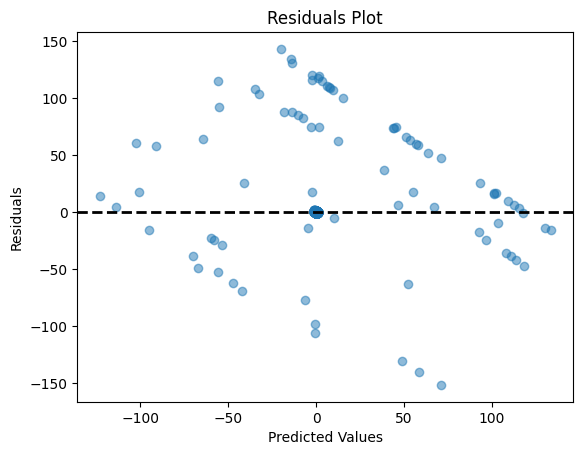

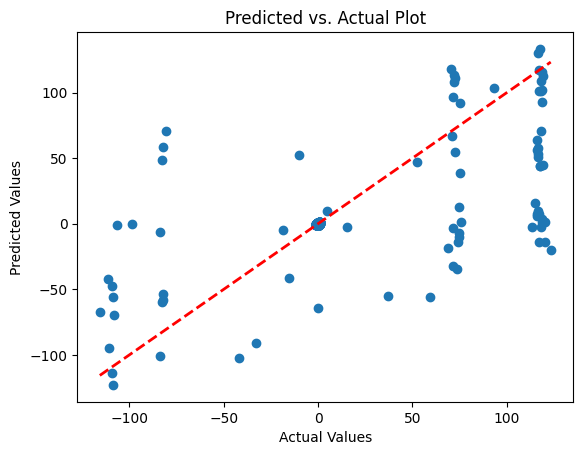

In [28]:
perform_linear_regression(A_block, target_block)

## Distance model (5 parameters)

Here we solve the following model

$$ s_i(k+1) = s_i(k) +\theta_{s_1}  s_i(k-1) +\theta_{s_2} s_i(k-2) +\theta_{s_3} v_i(k)   +\theta_{s_4} v_i(k-1) 
+\theta_{s_5} a_i(k)$$

### Data shifting

In [31]:
# Data shifting
A = np.vstack((
    s_x[2:-1],        #s[k]   
    s_x[1:-2],        #s[k-1]
    s_x[ :-3],        #s[k-2]
    v_x[2:-1],        #v[k]
    v_x[1:-2],        #v[k-1]
    a_x[2:-1]         #a[k]
    )).T


In [32]:

t = s_x[3:]
print("A matrix: " + str(A.shape))
print("target matrix: " + str(np.array(t).shape))



A matrix: (205180, 6)
target matrix: (205180,)


### Perform Linear Regression

Linear regression with 6 parameters
Coefficients:
0.9901234664322905
0.0001205865258245226
-0.0001503260039573775
0.04106114136177388
-0.0013225323137697493
-0.011967492126010879
Mean Squared Error: 15.396997620518437
R-squared (R2) Score: 0.9912479872940729


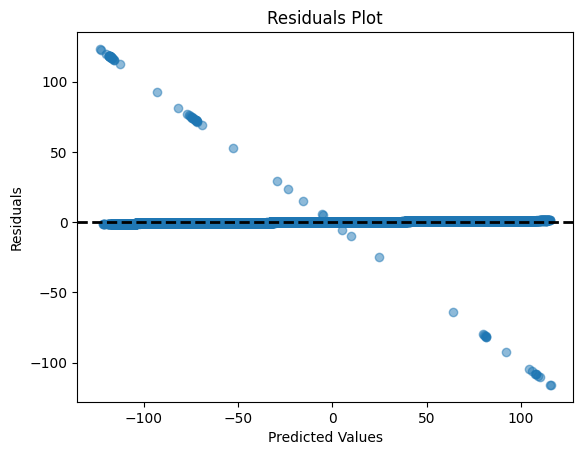

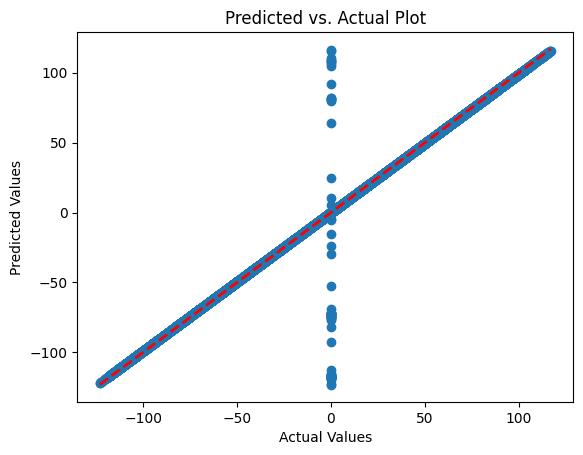

In [33]:
print("Linear regression with 6 parameters")
perform_linear_regression(A, t)

## Acceleration model (6 Parameters + 3 Extra)

### Data shifting

In [34]:
A = np.vstack([
    s_x[1:-2],          # s_i(k-1)
    s_x[0:-3],          # s_i(k-2)
    v_x[2:-1],          # v_i(k)
    v_x[1:-2],          # v_i(k-1)
    v_x[3:],            # v_i(k+1)
   -v_x[0:-3]           # -v_i(k-2)
]).T

# Target variable (s(k+1) - s(k))
t= np.array(s_x[3:] - s_x[2:-1])


print("A matrix: " + str(A.shape))
print("target matrix: " + str(np.array(t).shape))


A matrix: (205180, 6)
target matrix: (205180,)


### Normalisation step 
In this section we add the extra rows to achieve 9 parameters

In [35]:
def add_identity_block(A, B):
    B_zero = np.zeros((len(B), len(A.T)))
    A_zero = np.zeros((len(A), len(B.T)))
    return np.block([
        [A, A_zero], 
        [B_zero, B]])
n = 3               # Number of additional parameters
lambda_val = 0.9
identity_matrix = np.eye(n) * lambda_val
identity_matrix

A_block= add_identity_block(A, identity_matrix)
A_block.shape
target_block = np.concatenate([t, np.zeros(n)])
target_block.shape





(205183,)

### Perform Linear Regression 

Linear regression with (9  parameters
Coefficients:
-0.002315562397921303
-0.002912449034049165
-3.9688630860219947
0.009212242101078913
3.976429722742418
-0.024919960178032
0.013399963197686274
0.01339996319768641
0.013399963197686517
Mean Squared Error: 11.816595567558677
R-squared (R2) Score: 0.34648520415010997


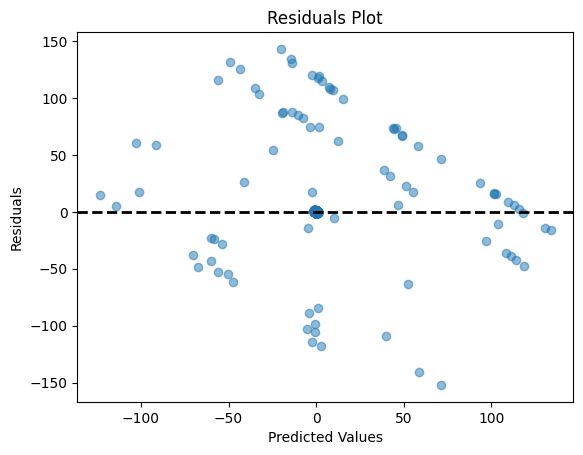

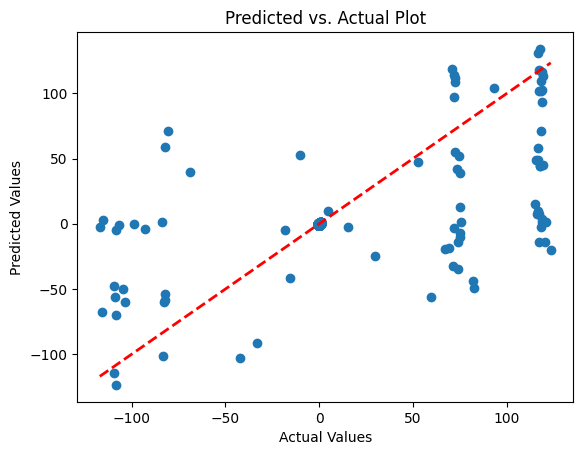

In [36]:
print("Linear regression with (9  parameters")
perform_linear_regression(A_block, target_block)

## Velocity model (4 parameters)

Here we solve the following model

$$\begin{align}
  v_i(k+1) &= \theta_{v_1}  v_i(k) + \theta_{v_2} v_i(k-1) + \theta_{v_3} v_i(k-2)   + \theta_{v_4} a_i(k)
\end{align}$$


### Data shifting

In [37]:
# Data shifting
A = np.vstack((
    v_x[2:-1],        #v[k]   
    v_x[1:-2],        #v[k-1]
    v_x[ :-3],        #v[k-2]
    a_x[2:-1]         #a[k]
    )).T


t = v_x[3:]
print("A matrix: " + str(A.shape))
print("target matrix: " + str(np.array(t).shape))



A matrix: (205180, 4)
target matrix: (205180,)


### Regression

Coefficients:
0.9970317019219092
3.339587757455651e-05
-0.0023414544187530875
0.05421752635537419
Mean Squared Error: 0.459645257153548
R-squared (R2) Score: 0.9912310407563348


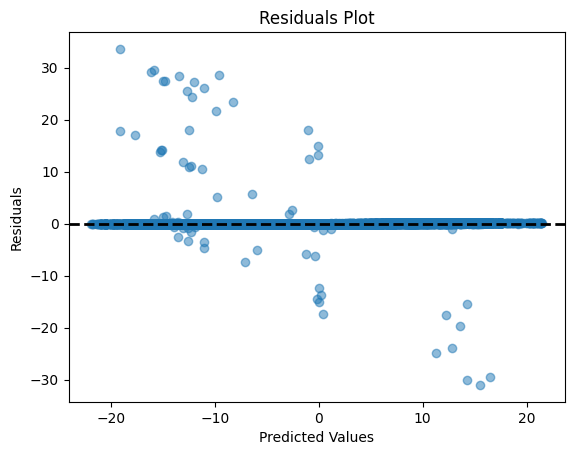

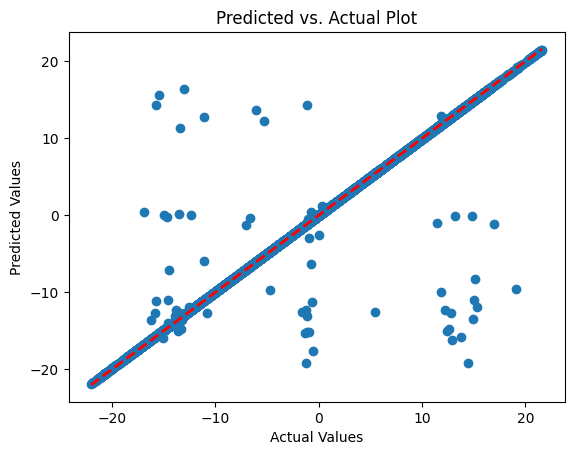

In [38]:
perform_linear_regression(A, t)

## Distance model (5 parameters)

Here we solve the following model

$$ s_i(k+1) = s_i(k) +\theta_{s_1}  s_i(k-1) +\theta_{s_2} s_i(k-2) +\theta_{s_3} v_i(k)   +\theta_{s_4} v_i(k-1) 
+\theta_{s_5} a_i(k)$$

### Data shifting

In [39]:
# Data shifting
A = np.vstack((
    s_x[2:-1],        #s[k]   
    s_x[1:-2],        #s[k-1]
    s_x[ :-3],        #s[k-2]
    v_x[2:-1],        #v[k]
    v_x[1:-2],        #v[k-1]
    a_x[2:-1]         #a[k]
    )).T

t = s_x[3:]
print("A matrix: " + str(A.shape))
print("target matrix: " + str(np.array(t).shape))



A matrix: (205180, 6)
target matrix: (205180,)


### Perform Linear Regression

Linear regression with 6 parameters
Coefficients:
0.9901234664322905
0.0001205865258245226
-0.0001503260039573775
0.04106114136177388
-0.0013225323137697493
-0.011967492126010879
Mean Squared Error: 15.396997620518437
R-squared (R2) Score: 0.9912479872940729


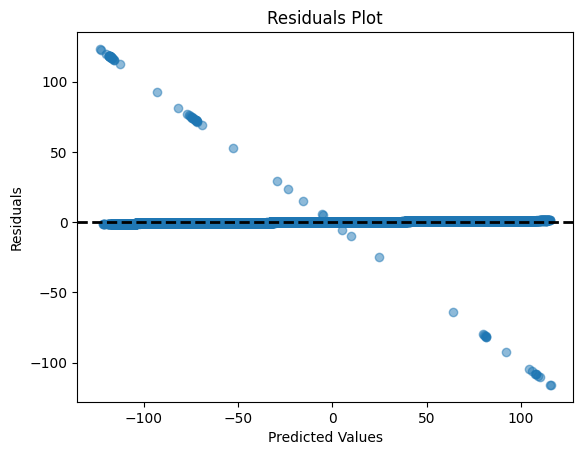

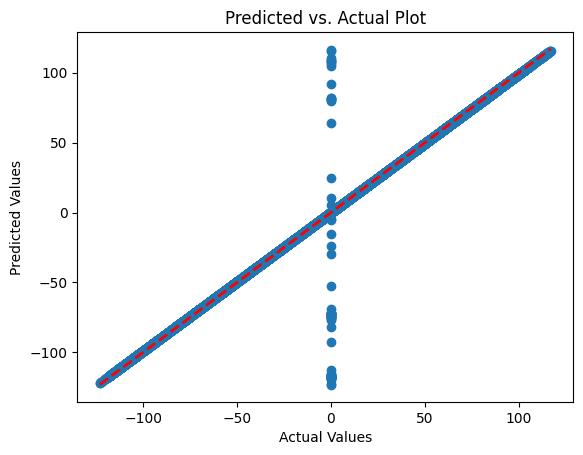

In [40]:
print("Linear regression with 6 parameters")
perform_linear_regression(A, t)